# COM2004/3004 - Lab Class Week 9
## Aim
We will implement “playground neural networks” in this lab class using PyTorch to solve the Two Spirals problem.


## Objectives


*   To gain some practical experience with deep neural network.
*   To compare the performance of different neural network architectures.
*   Implement recommand tanh activation function.
*   Experience neural network training.




## Using GPU
Training deep neural networks require a substantial amount of time using CPU only. We will use GPU to accelerate the training process in this lab. To enable GPU session in CoLab, we just simply select “Runtime” →  “Change Runtime” → “Hardware accelerator” →”GPU”

## Generate Two Spirals Data

Our experiment will conduct based on two spirals data. We have already demonstrated this in the lecture, two spirals is a rather complex task, and we need a “deep” architecture to solve this problem. We first generate 1000 data points for each class without adding noise.


(1000, 2) (1000,)


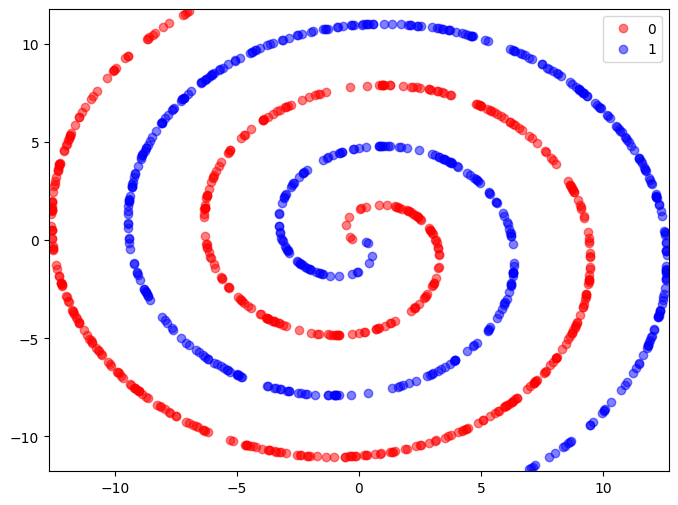

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def twospirals(n_points, noise=0):
    """
     Returns the two spirals dataset.
     https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()


X, y = twospirals(500)
print(X.shape, y.shape)
plot_data(X, y)

def plot_decision_boundary(func, X_tensor, y_tensor, figsize=(9, 6)):
    X = X_tensor.to("cpu").detach().numpy()
    y = y_tensor.to("cpu").detach().numpy()
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)

    aa, bb = np.meshgrid(hticks, vticks)
    ab = Variable(torch.from_numpy(np.c_[aa.ravel(), bb.ravel()]).float())
    c = func.pred(ab).detach().numpy()
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)

    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)


## Split training and testing sets

Similar to the previous lab class, we first split the data into training and testing sets. We could import sklearn package to help us with this. Read more about sklearn train_test_split [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)


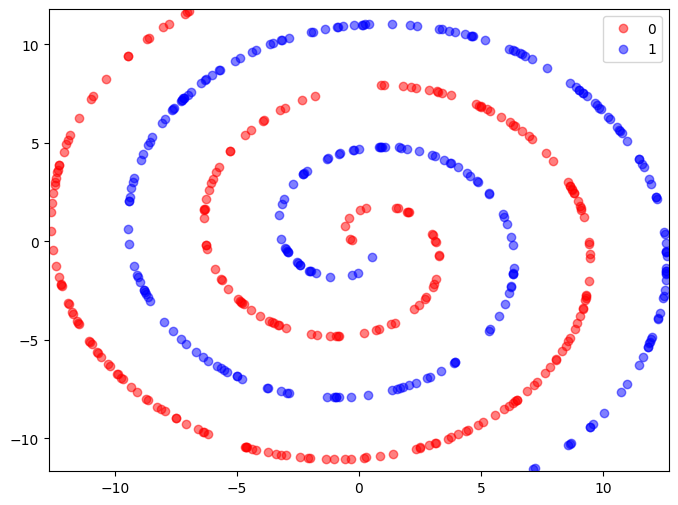

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

plot_data(X_train, y_train)

## Build Neural Network from Scrach

Now let’s start to build our first simple neural network. Since we are not rely on the Pytorch build-in modules, we just straight define the SimpleNN class without inheriting from nn.Module. Then we need to implement 5 parts in this class to make it works, they are:




1) ```def __init__(self):``` we can define the parameters required (w_1,b_1,w_2,b_2) for the network and initialise it randomly (torch.rand). We could also define the gradients with respect to these parameters (dw_1, db_1. dw_2, db2). We can initialise those gradients using (torch.zeros) to get zero gradients at the start. Please remember that those gradients has the same shape to the respective parameters.


2) ```def forward(self,x, train=False)```: This is forward pass. We can use torch.matmul for matrix multiplication. There is another matrix multiplication function in PyTorch is torch.mm. The advantage of using torch.matmul is it automatically broadcast the non-matrix (e.g. batch) dimensions.

3) ```train(self, data, num_epochs=10, lr=0.003)```: This is very similar to your previous lab train function, but you need to use your own implementation of backward and update functions

4) ```backward(self)```: This is the backward pass, please refer to last Friday’s lecture slides for the backpropagation. Please be aware we need to use torch.unsqueeze to make sure the shape is broadcastable.

5) ```def update(self, lr=0.003)```: This is the gradient decent part new_w = (w_old-lr*w_old)

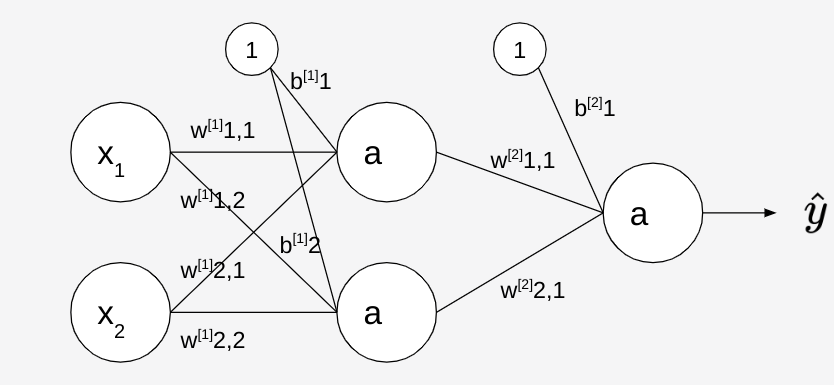

In [3]:
import torch
from torch import exp
import math


class SimpleNN:
  def __init__(self):
    self.w_1 = torch.rand(2,2)
    self.b_1 = torch.rand(2,1)
    self.w_2 = torch.rand(2,1)
    self.b_2 = torch.rand(1,1)

    self.dw_1 = torch.zeros(2,2)
    self.db_1 = torch.zeros(2,1)
    self.dw_2 = torch.zeros(2,1)
    self.db_2 = torch.zeros(1,1)


  def forward(self,x, train=False):
    #print(x.shape)
    x = torch.unsqueeze(x,2)
    #print(x.shape)

    net_1_linear_transformation = torch.matmul(torch.transpose(self.w_1,0,1),x)+self.b_1
    #print('net1 shape:',net_1_linear_transformation.shape)
    net_1_activation = self.sigmoid(net_1_linear_transformation)
    #print('a1 shape:',net_1_activation.shape)
    net_2_linear_transformation = torch.matmul(torch.transpose(self.w_2,0,1),net_1_activation)+self.b_2
    #print('net2 shape:',net_2_linear_transformation.shape)
    y_hat = self.sigmoid(net_2_linear_transformation)
    #print('yhat shape:',y_hat.shape)
    if train:
      return y_hat, net_2_linear_transformation, net_1_activation, net_1_linear_transformation
    else:
      return y_hat


  def train(self, data, num_epochs=10, lr=0.003):
    for epoch in range(num_epochs):
      for item in data:
        y_hat, net_2_linear_transformation, net_1_activation, net_1_linear_transformation = self.forward(item[0], train=True)
        loss = torch.sum(self.sqe(item[1], torch.squeeze(y_hat)))
        self.backward(item[1], y_hat, net_2_linear_transformation, net_1_activation, net_1_linear_transformation, item[0])
        self.update(lr=lr)


  def update(self, lr=0.003):
    self.w_1 = self.w_1 - lr*self.dw_1
    self.w_2 = self.w_2 - lr*self.dw_2
    self.b_1 = self.b_1 - lr*self.db_1
    self.b_2 = self.b_2 - lr*self.db_2


  def backward(self, y, y_hat, net_2_linear_transformation, net_1_activation, net_1_linear_transformation, x):
    y_newshape = torch.unsqueeze(y,dim=1)
    y_newshape = torch.unsqueeze(y_newshape,dim=2)
    x = torch.unsqueeze(x,2)
    #print('y:',y.shape)
    #print('y_hat:',y_hat.shape)
    #print('x:', x.shape)

    batch_size = x.shape[0]


    dldy = -2*(y_newshape-y_hat)
    dydnet2 = y_hat*(1-y_hat)
    dnet2dw2 = net_1_activation

    dnet2 = dldy*dydnet2
    dw_2 = torch.matmul(dnet2dw2, torch.transpose(dnet2,-1,-2))
    db_2 = dnet2

    dnet2da1 = self.w_2
    da1dnet1 = net_1_activation*(1-net_1_activation)
    dnet1dw1 = x


    da1 = torch.matmul(dnet2da1,dnet2)
    dnet1 = da1*da1dnet1
    #print("dnet1:", dnet1.shape)
    dw_1 = torch.matmul(dnet1dw1, torch.transpose(dnet1,-1,-2))
    db_1 = dnet1

    self.dw_1 = torch.sum(dw_1, dim=0)/batch_size
    self.dw_2 = torch.sum(dw_2, dim=0)/batch_size
    self.db_1 = torch.sum(db_1, dim=0)/batch_size
    self.db_2 = torch.sum(db_2, dim=0)/batch_size

    #return dw1, db1, dw2, db2

  def pred(self, data, thres=0.5):
    pred = self.forward(data)
    ans = []
    for t in pred:
      if t < thres:
        ans.append(0)
      else:
        ans.append(1)
    return torch.tensor(ans)


  # Sigmoid function
  @staticmethod
  def sigmoid(z):
    return 1/(1+exp(-z))

  # Square Error Loss
  @staticmethod
  def sqe(y, y_hat):
    #print('y:',y.shape)
    #print('yhat:',y_hat.shape)
    return (y-y_hat)**2


## Perpare the training data

Before we feed the training data to the model, we need to covert the data into PyTorch tensor format.



In [4]:
from torch.utils.data import DataLoader, TensorDataset

x_train_tensor = torch.tensor(X_train, dtype=torch.float, device="cpu")
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device="cpu")

## Train the Network

The training process should be the same as the previous one. Again you have 3 parameters to play with. They are 1) “learning_rate”: which controls how fast the net learns; 2) batch_size: which controls the number of samples to work through before updating the internal model parameters; 3) num_epochs: which controls the number of repeats of the training process. You can try to change these parameters and see how the net performs.


accuracy:  0.49
accuracy:  0.616


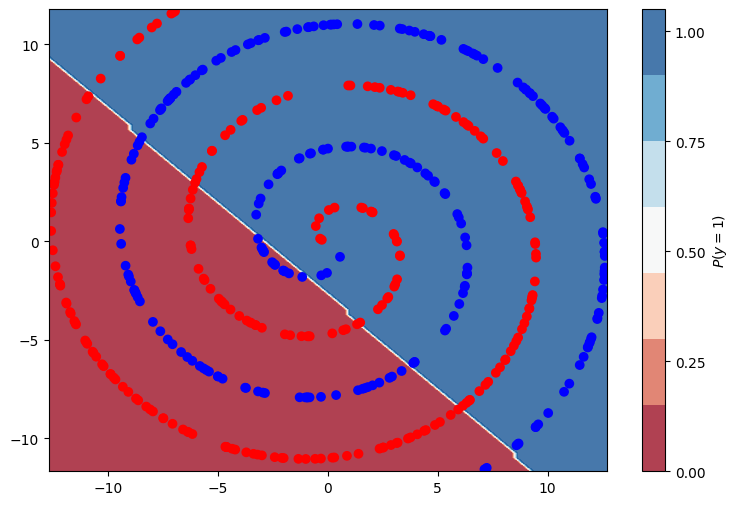

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from matplotlib.colors import ListedColormap
from datetime import datetime


learning_rate = 0.003
batch_size = 32
num_epochs = 500

dataset = TensorDataset(x_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
net = SimpleNN()

x_test_tensor = torch.tensor(X_test, dtype=torch.float)

#print(x_test_tensor)
test_pred = net.pred(x_test_tensor)
test_pred_np = test_pred.detach().numpy()

num_correct = np.sum(y_test == test_pred_np)
print("accuracy: ", num_correct/len(y_test))

net.train(loader,num_epochs=num_epochs, lr=learning_rate)


plot_decision_boundary(net, x_train_tensor, y_train_tensor)

test_pred = net.pred(x_test_tensor)
test_pred_np = test_pred.detach().numpy()

num_correct = np.sum(y_test == test_pred_np)
print("accuracy: ", num_correct/len(y_test))

## Build Neural Network Using PyTorch Building Function

Now let’s start to build our first simple neural network using PyTorch. To build our network, we first create a class (SimpleNN) that inherits from nn.Module. Then we need to implement two essential functions in this class. First is “__init__ “, which defines the layers of the neural network. In the figure, we have two input neurons (x1, and x2), two hidden neurons and two output neurons (class 0 and 1). Hence four units need to be defined in the __init__



```
self.layer_1_net = nn.Linear(2,2,bias=True) #nn.Linear defines a linear transformation between two layers. In our example, the input layer has two neurons, and the hidden layer has two neurons. Hence two positional arguments are 2 and 2, respectively. Bias=True will automatically add the bias to the transformation.
self.layer_1_activation = nn.Sigmoid() # nn.Sigmoid() defines a sigmoid activation function
self.layer_2_net = nn.Linear(2,2,bias=True) ## This defines the linear transformation from the hidden layer to the output layers. Again we have 2 neurons in the hidden layer and 2 neurons in the output layer.
self.softmax = nn.LogSoftmax(dim=1) ## This defines log softmax activation function
  ```


The second function we need to implement is the “forward” function. Which defines the forward pass calculation.

```
net_1_linear_transformation = self.layer_1_net(x) # x is out input, we pass the input to the layer_1_net linear transformation
net_1_activation = self.layer_1_activation(net_1_linear_transformation) #After we obtain the linear transformation, we pass the net_1_linear_transformation to the activation function.
net_2_linear_transformation = self.layer_2_net(net_1_activation) # similar to layer 1 linear transformation, now we conduct linear transformation from hidden layer to output layer
softmaxed_output = self.softmax(net_2_linear_transformation) # Apply softmax activation function
```


In [6]:
import torch
from torch import nn


class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    ## implement your layers here

    # nn.Linear defines a linear transformation between two layers. In our example, the input layer has two neurons, and the hidden layer has two neurons. Hence two positional arguments are 2 and 2, respectively.
    # Bias=True will automatically add the bias to the transformation. Read more about nn.Linear here: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    self.layer_1_net = nn.Linear(2,2,bias=True)
    # nn.Sigmoid() defines a sigmoid activation function. Please check here for other activation functions: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
    self.layer_1_activation = nn.Sigmoid()
    # Similar to layer 1 linear transformation, now we conduct linear transformation from hidden layer to output layer
    self.layer_2_net = nn.Linear(2,1,bias=True)
    # Again we need a activation function
    self.layer_2_activation = nn.Sigmoid()


  def forward(self,x):
    # x is our input, we pass the input to the layer_1_net linear transformation
    net_1_linear_transformation = self.layer_1_net(x)
    #After we obtain the linear transformation, we pass the net_1_linear_transformation to the activation function.
    net_1_activation = self.layer_1_activation(net_1_linear_transformation)
    # similar to layer 1 linear transformation, now we conduct linear transformation from hidden layer to output layer
    net_2_linear_transformation = self.layer_2_net(net_1_activation)
    # Apply Sigmoid activation function
    layer_2_activation = self.layer_2_activation(net_2_linear_transformation)
    return layer_2_activation

  def train(self, data, num_epochs=10, lr=0.003):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    for epoch in range(num_epochs):
      for item in data:
        out = self(item[0])
        optimizer.zero_grad()

        loss = criterion(torch.squeeze(out), item[1])
        loss.backward()
        optimizer.step()

  def pred(self, data, thres=0.5):
    pred = self.forward(data)
    ans = []
    for t in pred:
      if t < thres:
        ans.append(0)
      else:
        ans.append(1)
    return torch.tensor(ans)



In [7]:

def recommand_tanh(x):
  #print(x)
  return 1.7159*torch.tanh((2/3)*x)


class BetterNN(nn.Module):
  def __init__(self):
    ## implement your layers here
    super().__init__()
    self.layer_1_net = nn.Linear(2,800,bias=True)
    self.layer_1_activation = recommand_tanh
    self.layer_1_1_net = nn.Linear(800,800,bias=True)
    self.layer_1_1_activation = recommand_tanh
    self.layer_2_net = nn.Linear(800,1,bias=True)
    self.layer_2_activation = nn.Sigmoid()


  def forward(self,x):
    net_1_linear_transformation = self.layer_1_net(x)
    net_1_activation = self.layer_1_activation(net_1_linear_transformation)
    net_1_1_linear_transformation = self.layer_1_1_net(net_1_activation)
    net_1_1_activation = self.layer_1_1_activation(net_1_1_linear_transformation)
    net_2_linear_transformation = self.layer_2_net(net_1_1_activation)
    layer_2_activation = self.layer_2_activation(net_2_linear_transformation)
    return layer_2_activation

  def train(self, data, num_epochs=10, lr=0.003):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    for epoch in range(num_epochs):
      for item in data:
        out = self(item[0])
        optimizer.zero_grad()
        loss = criterion(torch.squeeze(out), item[1])
        loss.backward()
        optimizer.step()

  def pred(self, data, thres=0.5):
    pred = self.forward(data)
    ans = []
    for t in pred:
      if t < thres:
        ans.append(0)
      else:
        ans.append(1)
    return torch.tensor(ans)







## Train the Network

We are not cover the training part yet but don’t worry. The training function is implemented in the SimpleNN. There are three parameters that could affect the performance of the trained net. They are 1) “learning_rate”: which controls how fast the net learns; 2) batch_size: which controls the number of samples to work through before updating the internal model parameters; 3) num_epochs: which controls the number of repeats of the training process. You can try to change these parameters and see how the net performs.


time spend in the training:  0:00:10.831138
time spend in the training:  0:00:27.593629


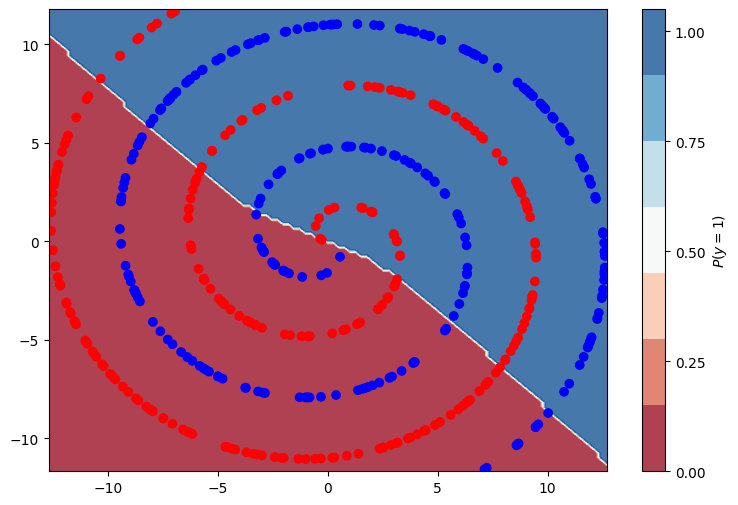

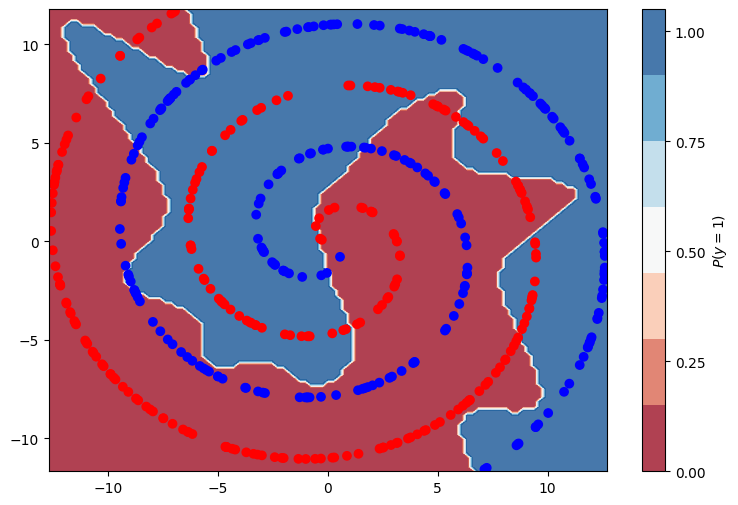

In [8]:
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from matplotlib.colors import ListedColormap
from datetime import datetime


learning_rate = 0.003
batch_size = 32
num_epochs = 500

dataset = TensorDataset(x_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=batch_size)

net = SimpleNN()
net.to("cpu")
strat_time = datetime.now()
net.train(loader,num_epochs=num_epochs, lr=learning_rate)
end_time = datetime.now()

print('time spend in the training: ', end_time - strat_time)


plot_decision_boundary(net, x_train_tensor, y_train_tensor)


better_net = BetterNN()
better_net.to("cpu")
strat_time = datetime.now()
better_net.train(loader,num_epochs=num_epochs, lr=learning_rate)
end_time = datetime.now()

print('time spend in the training: ', end_time - strat_time)
plot_decision_boundary(better_net, x_train_tensor, y_train_tensor)


## Evaluate the model performance on the testing dataset

accuracy:  0.614
              precision    recall  f1-score   support

         0.0       0.62      0.61      0.62       255
         1.0       0.60      0.62      0.61       245

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500



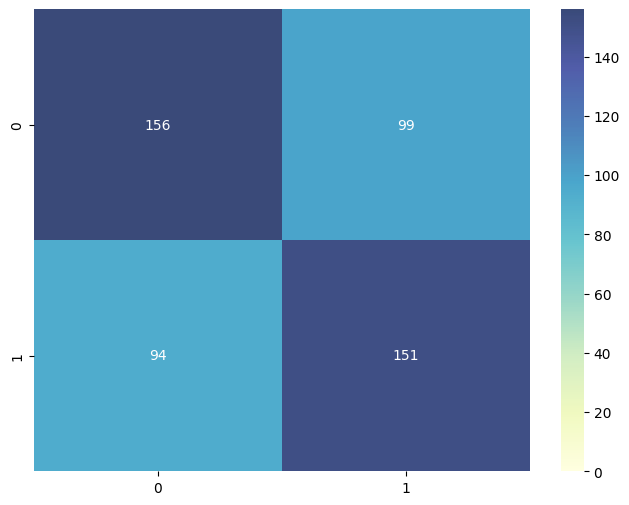

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)


x_test_tensor = torch.tensor(X_test, dtype=torch.float)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_pred = net.pred(x_test_tensor)
test_pred_np = test_pred.detach().numpy()

num_correct = np.sum(y_test == test_pred_np)
print("accuracy: ", num_correct/len(y_test))

classification_results = classification_report(y_test, test_pred_np)
print(classification_results)
plot_confusion_matrix(y_test, test_pred_np)



## Accelerate using GPU

We already changed the runtime to GPU. However, we have not yet put our network and data to GPU to accelerate. In order to enable GPU acceleration, we need first to convert the net and data to “cuda” device. Give it a go and see if there is any “acceleration” using GPU.


In [10]:
if torch.cuda.is_available():
  num_epochs = 1200


  x_train_tensor = x_train_tensor.to("cuda")
  y_train_tensor = y_train_tensor.to("cuda")

  dataset = TensorDataset(x_train_tensor, y_train_tensor)
  loader = DataLoader(dataset, batch_size=batch_size)

  net.to("cuda")
  strat_time = datetime.now()
  net.train(loader,num_epochs=num_epochs, lr=learning_rate)
  end_time = datetime.now()

  print('time spend in the training: ', end_time - strat_time)
  # put model back to cpu for plotting
  net.to("cpu")
  plot_decision_boundary(net, x_train_tensor, y_train_tensor)
else:
  print("GPU is not available")


GPU is not available


## Implement recommand tanh function

Do you remember the recommand tanh function. Try to implement it and plug to your network.

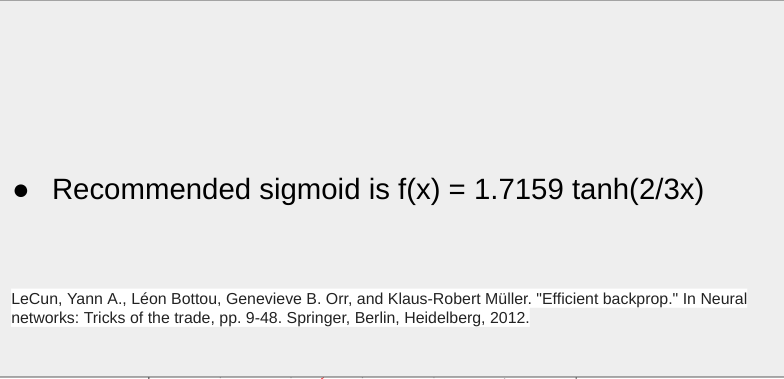

## Improve the performance

Could you improve the network accuracy by add more layers or neurons?
Try to replace the activation function


# COM2004/3004 - Lab Class Week 9 Part 2
## Aim
In the first part of this lab, we will implement a CNN to solve the hand write digits recognition problem.

## Objectives

*   To gain some practical experience with CNN.


## Perpare Data

We will use LeCun's dataset for this experiment. ```torchvision.datasets``` already collected the dataset for us called MNIST. We could simply load the dataset using ```torchvision.datasets.MNIST```


In [11]:
import torchvision
train_data = torchvision.datasets.MNIST('/files/', train=True, download=True)
test_data = torchvision.datasets.MNIST('/files/', train=False, download=True)

ModuleNotFoundError: No module named 'torchvision'

## Perpare the training data

Before we feed the training data to the model, we need to covert the data into PyTorch tensor format.


In [ ]:
import matplotlib.pyplot as plt

# The inputs (x) of the data are stored in data
train_data_x = train_data.data
# Lets check the shape of the input, please beaware the input shape for nn.Conv2d is (N,C,H,W)
# N is the batch size, C is the number of channels, H is a height of input planes in pixels and W is width in pixels
print(train_data_x.shape)
# Since we don't have the channel dimension in the training data, we need to add this information using torch.unsqueeze.
# Which returns a new tensor with a dimension of size one inserted at the specified position.
train_data_x = torch.unsqueeze(train_data_x, dim=1)
print(train_data_x.shape)
train_data_x = train_data_x.type(torch.float)
train_label = train_data.targets
print(train_label.shape)

# Lets plot the data and see what they are look like
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_data_x[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_label[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Convert data into cuda format, ready for GPU process
train_label = train_label.to("cuda")
train_data_x = train_data_x.to("cuda")


## Build Neural Network

Now let’s start to build our first simple convolutional neural network using PyTorch. Similar to the previous feedforward network building, we first create a class (SimpleCNN) that inherits from nn.Module. Then we need to implement two essential functions in this class. First is ```__init__```, which defines the layers of the neural network. In the figure, we have two convelutional layers and two pooling layers. Then followed by a fully connected layer. Since two pooling layers don’t have any training parameters, we are not bothering to define them here. Just a reminder here, you can use nn.Conv2d to define your convolutional layers and nn.Linear for the fully connected layers.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # First convelutional layer 1 channel in with 10 filters, kernel_size = 5*5
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    # Second convelutional layer 10 channel in with 20 filters, kernel_size = 5*5
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.fc1 = nn.Linear(320, 10)

  def forward(self, x):
    conv_1 = self.conv1(x)
    pool_1 = F.max_pool2d(conv_1, 2)
    a_1 = F.relu(pool_1)
    conv_2 = self.conv2(a_1)
    pool_2 = F.max_pool2d(conv_2, 2)
    a_2 = F.relu(pool_2)

    # flatten process
    flat_a_2 = a_2.view(-1, 320)
    fc_out = self.fc1(flat_a_2)
    return fc_out

  def train(self, data, num_epochs=10, lr=0.003):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=lr)
    for epoch in range(num_epochs):
      print("training epoch: ", epoch)
      for item in data:
        out = self(item[0])
        optimizer.zero_grad()
        loss = criterion(out, item[1])
        loss.backward()
        optimizer.step()


  def pred(self, data, thres=0.5):
    # We have 10 outputs represent the probabilities of 10 digits
    # We need find the digits with highest probability with argmax method
    pred_output = self.forward(data)
    #print(pred_output.shape)
    argmax = pred_output.argmax(1)
    #print(argmax.shape)
    return argmax







## Train the Network

Again, there is nothing differnt to the fully connected neural network training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

learning_rate = 0.003
num_epochs = 10
batch_size = 32

net = SimpleCNN()
net.to("cuda")
train_loader = DataLoader(TensorDataset(train_data_x, train_label), batch_size=batch_size, shuffle=True)
net.train(train_loader,num_epochs=num_epochs, lr=learning_rate)

## Evaluate the model performance on the testing dataset

Could you write you evaluation function here?
You can reuse the confusion matrix code from above to generate the confusion matrix

In [ ]:
test_data_x = test_data.data
test_data_x = torch.unsqueeze(test_data_x, dim=1)
test_data_x = test_data_x.type(torch.float)
print(test_data_x.shape)

test_label = test_data.targets
test_label = test_label.to("cuda")

test_data_x = test_data_x.to("cuda")

test_loader = DataLoader(TensorDataset(train_data_x, train_label), batch_size=batch_size)

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(y, y_pred):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

import numpy as np
all_pred = []
all_label = []
for item in test_loader:
  pred_out = net.pred(item[0])
  pred_out = pred_out.to('cpu').detach().numpy().tolist()
  label = item[1].to('cpu').detach().numpy().tolist()
  all_pred += pred_out
  all_label += label

accuracy = np.sum(np.array(all_pred) == np.array(all_label))/(len(all_label))
print(accuracy)

classification_results = classification_report(all_pred, all_label)
print(classification_results)

plot_confusion_matrix(all_pred, all_label)